<a href="https://colab.research.google.com/github/risha-gandhi/machine-learning-assignments/blob/main/Ridge_and_LASSO_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Part 1: Load and prep the data (5 pts)


In this assignment we'll look at the affect of using regularization on linear regression models that we train. You will write code to train models that use different regularizers and different penalties and to analyze how this affects the model.

For this assignment, we will only be using a very small subset of the data to do our analysis. This is not something you would usually do in practice, but is something we do for this assignment to simplify this complexity of this dataset. The data is pretty noisy and to get meaningful results to demonstrate the theoretical behavior, you would need to use a much more complicated set of features that would be a bit more tedious to work with.

Use ``home_data.csv.``

In [ ]:
# TODO: Load the data using pandas - you can look at Assignment 1 if you have forgotten how to do this.
sales = pd.read_csv("home_data.csv")
# Selects 1% of the data
sales = sales.sample(frac=0.01, random_state=0) 

print(f'Number of points: {len(sales)}')
sales.head()

Number of points: 216


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
17384,1453602313,20141029T000000,297000,2,1.50,1430,1650,3.0,0,0,3,7,1430,0,1999,0,98125,47.7222,-122.290,1430,1650
722,2225059214,20140808T000000,1578000,4,3.25,4670,51836,2.0,0,0,4,12,4670,0,1988,0,98005,47.6350,-122.164,4230,41075
2680,2768000270,20140625T000000,562100,2,0.75,1440,3700,1.0,0,0,3,7,1200,240,1914,0,98107,47.6707,-122.364,1440,4300
18754,6819100040,20140624T000000,631500,2,1.00,1130,2640,1.0,0,0,4,8,1130,0,1927,0,98109,47.6438,-122.357,1680,3200
14554,4027700666,20150426T000000,780000,4,2.50,3180,9603,2.0,0,2,3,9,3180,0,2002,0,98155,47.7717,-122.277,2440,15261


First, we do a bit of feature engineering by creating features that represent the squares of each feature and the square root of each feature. One benefit of using regularization is you can include more features than necessary and you don't have to be as worried about overfitting since the model is regularized.

In [ ]:
from math import sqrt

# All of the features of interest
features = [
    'bedrooms', 
    'bathrooms',
    'sqft_living', 
    'sqft_lot', 
    'floors', 
    'waterfront', 
    'view', 
    'condition', 
    'grade',
    'sqft_above',
    'sqft_basement',
    'yr_built', 
    'yr_renovated'
]

# Compute the square and sqrt of each feature
all_features = []
for feat in features:
    square_feat = feat + '_square' 
    sqrt_feat = feat + '_sqrt'
    
    sales[square_feat] = sales[feat] ** 2
    sales[sqrt_feat] = sales[feat].apply(sqrt)
    
    all_features.extend([feat, square_feat, sqrt_feat])
    
print(sales.head())

X = sales[all_features]
y = sales['price']

               id             date  ...  yr_renovated_square  yr_renovated_sqrt
17384  1453602313  20141029T000000  ...                    0                0.0
722    2225059214  20140808T000000  ...                    0                0.0
2680   2768000270  20140625T000000  ...                    0                0.0
18754  6819100040  20140624T000000  ...                    0                0.0
14554  4027700666  20150426T000000  ...                    0                0.0

[5 rows x 47 columns]


Next, we will split the data set into training, validation, and test sets. For this assignment we will use 70% of the data to train, 10% for validation, and 20% to test. 

We have written most of the splitting for you, but we need you to figure out what the sizes should be in this case based off the numbers above. Remember, we use `random_state=6` to make sure the results are the same for everyone on this assignment. 
*Hint: You should print out the length of the datasets to make sure you got it right!*

In [ ]:
# TODO Make train/test splits of the right size.
from sklearn.model_selection import train_test_split
X_train_and_validation, X_test, y_train_and_validation, y_test  =  train_test_split(X, y, test_size = 0.2, random_state = 6) # TODO: Make the test set 20%
X_train, X_val, y_train, y_val = train_test_split(X_train_and_validation, y_train_and_validation, test_size = 0.125, random_state = 6)# TODO: Make the val set 10% of the total data (not 10% of X_train_and_validation)
print(X_train.shape, X_val.shape, X_test.shape)


(150, 39) (22, 39) (44, 39)


We first need to do a little bit more pre-processing to prepare the data for model training. Models like Ridge and LASSO assume the input features are standardized (mean 0, std. dev. 1) and the target values are centered (mean 0). If we do not do this, we might get some unpredictable results since we violate the assumption of the models!

We can use Sklearn's Standard scaler to do this - for each feature we learn the mean $\mu$ and standard deviation $\sigma$ and then rescale that feature for each point. Ie., if that feature used to be $x$ it is now $\frac{x - \mu}{s}$.

See [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) for more info. Note that we learn it on the training set and then apply it to the validation set and test set. We also center the depenent variable $y$-values.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
y_train = y_train - np.mean(y_train)

X_test = scaler.transform(X_test)
y_test = y_test - np.mean(y_train)

X_val = scaler.transform(X_val)
y_val = y_val - np.mean(y_train)

### Part 2: Linear Regression (5 pts)
As a baseline, we will first, train a regular `LinearRegression` model on the data using the features in `all_features` and compute its **test RMSE** . The RMSE is the square root of the mean squared error. 

In [ ]:
# TODO Train a linear regression model - you may need to import LinearRegression and mean_squared_error from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

# TODO - compute and compare the RMSE on the train and test data.
train_rmse = math.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse =  math.sqrt(mean_squared_error(y_test, y_pred))
print('Train', train_rmse)
print('Test', test_rmse)

Train 142457.31542346903
Test 675086.2425484249


--- 
### Part 3: Ridge Regression (10pts)


In this section, we will do some **hyper-parameter tuning** to find the optimal setting of the regularization constant $\lambda$ for Ridge Regression. Remember that $\lambda$ is the coefficient that controls how much the model is penalized for having large weights in the optimization function.

$\hat{w}_{ridge} = \min_w RSS(w) + \lambda \left\lVert w \right\rVert_2^2$

where $\left\lVert w \right\rVert_2^2 = \sum_{j=0}^D w_j^2$ is the L2 norm of the parameters. By default, `sklearn`'s `Ridge` class does not regularize the intercept - you should never regularize the intercept

For this part of the assignment, you will be writing code to find the optimal setting of the penalty $\lambda$. Below, we describe what steps you will want to have in your code to compute these values:

*Implementation Details*
* Use the following choices of L2 penalty: $[10^{-5}, 10^{-4}, ..., 10^4, 10^5]$. In Python, you can create a list of these numbers using `np.logspace(-5, 5, 11)`. 
* Use the [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) class from sklearn to train a Ridge Regression model on the **training** data. The **only** parameters you need to pass when constructing the Ridge model are `alpha`, which lets you specify what you want the L2 penalty to be, and `random_state=0` to avoid randomness.
* Evaluate both the training error and the validation error for the model by reporting the RMSE of each dataset.
* Put all of your results in a pandas `DataFrame` named `ridge_data` so you can analyze them later. The `ridge_data` should have a row for each L2 penalty you tried and should have the following columns:
  * `l2_penalty`: The L2 penalty for that row
  * `model`: The actual `Ridge` model object that was trained with that L2 penalty
  * `train_rmse`: The training RMSE for that model
  * `validation_rmse`: The validation RMSE for that model

*Hints: Here is a  strategy that you might find helpful*
* You will need a loop to loop over the possible L2 penalties. Try writing a lot of the code without a loop first if you're stuck to help you figure out how the pieces go together. You can safely ignore building up the result `DataFrame` at first, just print all the information out to start! 
* If you are running into troubles writing your loop, try to print values out to investigate what's going wrong.
* Remember to use RMSE for calculating the error!


In [ ]:
# TODO 
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

l2_penalties = np.logspace(-5, 5, 11) # TODO: make the list of lambda values
ridge_data = []

for l2_penalty in l2_penalties:
    print(l2_penalty)
    model = Ridge(alpha= l2_penalty, random_state = 0)#TODO: Train a Ridge regression model using Ridge in sklearn. Remember that alpha is the lambda parameter from class. Use random_state=0
    model.fit(X_train,y_train)
    y_pred = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    train_rmse = math.sqrt(mean_squared_error(y_train, y_pred)) #TODO: compute RMSE on the train set
    validation_rmse = math.sqrt(mean_squared_error(y_val, y_pred_val)) # TODO: compute RMSE on the validation set
    
    # We maintain a list of dictionaries containing our results
    ridge_data.append({
        'l2_penalty': l2_penalty,
        'model': model,
        'train_rmse': train_rmse,
        'validation_rmse': validation_rmse})
    
ridge_data = pd.DataFrame(ridge_data) # We will put this data into a datframe to make it easier to use later.
print(ridge_data)

1e-05
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0
      l2_penalty  ... validation_rmse
0        0.00001  ...   643241.226105
1        0.00010  ...   643479.885343
2        0.00100  ...   641921.798386
3        0.01000  ...   614600.996092
4        0.10000  ...   572434.297452
5        1.00000  ...   550761.625114
6       10.00000  ...   548518.261356
7      100.00000  ...   567371.418909
8     1000.00000  ...   641193.052000
9    10000.00000  ...   762923.644311
10  100000.00000  ...   797592.043545

[11 rows x 4 columns]


As a sanity check, the cells below make sure you have a variable named `ridge_data` with the right number of rows and columns. If nothing is printed out, you pass this sanity check! 

In [ ]:
assert type(ridge_data) == pd.DataFrame
assert len(ridge_data) == 11

for col in ['l2_penalty', 'model', 'train_rmse', 'validation_rmse']:
    assert col in ridge_data.columns, f'Missing column {col}'

### Part 4: Investigating Ridge Regression Results (5pts)

Next, let's investigate how the penalty affected the train and validation error by running the following plotting code

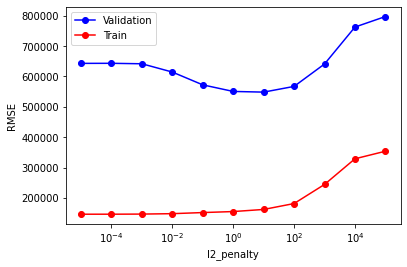

In [ ]:
# Plot the validation RMSE as a blue line with dots
plt.plot(ridge_data['l2_penalty'], ridge_data['validation_rmse'], 
         'b-o', label='Validation')
# Plot the train RMSE as a red line dots
plt.plot(ridge_data['l2_penalty'], ridge_data['train_rmse'], 
         'r-o', label='Train')

# Make the x-axis log scale for readability
plt.xscale('log')

# Label the axes and make a legend
plt.xlabel('l2_penalty')
plt.ylabel('RMSE')
plt.legend()

Next, we want to actually look at which model we think will perform best. First we define a helper function that will be used to inspect the model parameters.

In [ ]:
def print_coefficients(model, features):
    """
    This function takes in a model column and a features column. 
    And prints the coefficient along with its feature name.
    """
    feats = list(zip(model.coef_, features))
    print(*feats, sep = "\n")

In the cell below, write code that uses the `ridge_data` `DataFrame` to select which L2 penalty we would choose based on the evaluations we did in the previous section. You should print out the following values to help you answer the next questions! 
* The best L2 penalty based on the model evaluations
* Take the best model and evaluate its error on the **test** dataset. Report the number as an RMSE.
* Call the `print_coefficients` function passing in the model itself and the features used so you can look at all of its coefficient values.

To do this in `pandas`, you'll need to use the `idxmin()` function to find the index of the smallest value in a column and the `loc` property to access that index. As an example, suppose we had a `DataFrame` named `df`:

| a | b | c |
|---|---|---|
| 1 | 2 | 3 |
| 2 | 1 | 3 |
| 3 | 2 | 1 |

If we wrote the code 
```python
index = df['b'].idxmin()
row = df.loc[index]
```

It would first find the index of the smallest value in the `b` column and then uses the `.loc` property of the `DataFrame` to access that particular row. It will return a `Series` object (basically a Python dictionary) which means you can use syntax like `row['a']` to access a particular column of that row.

In [ ]:
# ridge_data.append({
#         'l2_penalty': l2_penalty,
#         'model': model,
#         'train_rmse': train_rmse,
#         'validation_rmse': validation_rmse})

# TODO Print information about best L2 model
index = ridge_data['validation_rmse'].idxmin()
best_ridge = ridge_data.loc[index]#TODO: Which model has the lowest RMSE on the validation set?
y_pred_test = best_ridge['model'].predict(X_test)

test_rmse = math.sqrt(mean_squared_error(y_test, y_pred_test)) # TODO: compute the RMSE on the Test set.
print('Best L2 Penalty', best_ridge['l2_penalty'])
print('TEST RMSE', test_rmse)
print_coefficients(best_ridge['model'], all_features) 

Best L2 Penalty 10.0
TEST RMSE 626479.191939315
(-12814.960695689748, 'bedrooms')
(-5578.58562755392, 'bedrooms_square')
(-19987.878641088646, 'bedrooms_sqrt')
(-261.2331046005436, 'bathrooms')
(139717.20930550515, 'bathrooms_square')
(-50659.47327155908, 'bathrooms_sqrt')
(23125.50416726878, 'sqft_living')
(19304.65519120802, 'sqft_living_square')
(14413.31922599656, 'sqft_living_sqrt')
(18909.07641753274, 'sqft_lot')
(21375.20111150273, 'sqft_lot_square')
(-25079.695226768985, 'sqft_lot_sqrt')
(-15962.664049881238, 'floors')
(13961.951626360678, 'floors_square')
(-27220.383772045923, 'floors_sqrt')
(43800.14749775992, 'waterfront')
(43800.147497760336, 'waterfront_square')
(43800.14749776029, 'waterfront_sqrt')
(-7513.023932352359, 'view')
(11529.923304894017, 'view_square')
(-12278.67285084605, 'view_sqrt')
(4224.607744785577, 'condition')
(4624.595688989772, 'condition_square')
(4026.45544462523, 'condition_sqrt')
(44871.77670857457, 'grade')
(73624.90237512332, 'grade_square')
(31

 **Question A:**  Based on your evaluations, which L2 penalty would you use?

*I would choose a L2 penalty of 10*

 **Question B:**  For the model you chose for the Q2, what is its test RMSE?

*The test RMSE is 626479.19*

 **Question C:**  For the model you chose in Q2, what is the number of features that have coefficient 0?

*We have no features with coefficients of 0*



--- 
### Part 5: LASSO Regression (5 pts)
In this section you will do basically the exact same analysis you did with Ridge Regression, but using LASSO Regression instead. Remember that for LASSO we choose the parameters that minimize this quality metric instead 

$$\hat{w}_{LASSO} = \min_w RSS(w) + \lambda \left\lVert w \right\rVert_1$$

where $\left\lVert w \right\rVert_1 = \sum_{j=0}^D | w_j |$ is the L1 norm of the parameter vector.

We will use the same set of instructions for LASSO as we did for Ridge, except for the following differences. Please refer back to the Ridge Regression instructions and your code to see how these differences fit in!

* Use the [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) model. Like before, the only parameters you need to pass in are `alpha` for the L1 penalty and `random_state=0`.
* The range L1 penalties should be $[10, 10^2, ..., 10^7]$. In Python, this is `np.logspace(1, 7, num=7)`.
* The result should be stored in a `DataFrame` named `lasso_data`. All the columns should have the same name and corresponding values except the penalty column should be called `l1_penalty`.
* It is okay if your code prints some `ConvergenceWarning` warnings, these should not impact your results!.

You do not need to worry about your code being redundant for this part.

In [ ]:
# TODO: Compute a lasso regression. See the Ridge Regression section for a model of what to do here
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

l1_penalties = np.logspace(1, 7, num=7) # TODO: make the list of lambda values
lasso_data = []

for l1_penalty in l1_penalties:
    print(l1_penalty)
    model = Lasso(alpha= l1_penalty, random_state = 0)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    train_rmse = math.sqrt(mean_squared_error(y_train, y_pred)) # TODO: compute RMSE on the train set
    validation_rmse = math.sqrt(mean_squared_error(y_val, y_pred_val)) # TODO: compute RMSE on the validation set
    
    # We maintain a list of dictionaries containing our results
    lasso_data.append({
        'l1_penalty': l1_penalty,
        'model': model,
        'train_rmse': train_rmse,
        'validation_rmse': validation_rmse})
    
lasso_data = pd.DataFrame(lasso_data) # We will put this data into a datframe to make it easier to use later.
print(lasso_data)

10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000000.0
   l1_penalty  ... validation_rmse
0        10.0  ...   574102.178744
1       100.0  ...   561653.281862
2      1000.0  ...   536906.548347
3     10000.0  ...   555771.690167
4    100000.0  ...   643989.904483
5   1000000.0  ...   802207.512615
6  10000000.0  ...   802207.512615

[7 rows x 4 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.653e+12, tolerance: 1.913e+09
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.000e+12, tolerance: 1.913e+09
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

Here is a sanity check like before.

In [ ]:
assert type(lasso_data) == pd.DataFrame
assert len(lasso_data) == 7

for col in ['l1_penalty', 'model', 'train_rmse', 'validation_rmse']:
    assert col in lasso_data.columns, f'Missing column {col}'

### Part 6:  Investigating Lasso ( 5 pts)

Like before, let's look at how the L1 penalty affects the performance.

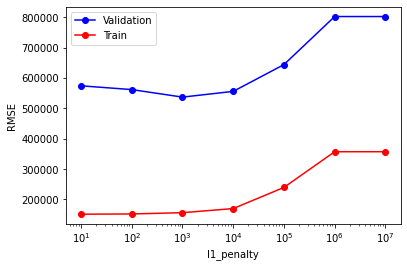

In [ ]:
# Plot the validation RMSE as a blue line with dots

plt.plot(lasso_data['l1_penalty'], lasso_data['validation_rmse'],
         'b-o', label='Validation')

# Plot the train RMSE as a red line dots
plt.plot(lasso_data['l1_penalty'], lasso_data['train_rmse'],
         'r-o', label='Train')

# Make the x-axis log scale for readability
plt.xscale('log')

# Label the axes and make a legend
plt.xlabel('l1_penalty')
plt.ylabel('RMSE')
plt.legend()

Like before, in the cell below, write code that uses the `lasso_data` `DataFrame` to select which L1 penalty we would choose based on the evaluations we did in the previous section. You should print out the following values to help you answer the next questions! 
* The best L1 penalty based on the model evaluations
* Take the best model and evaluate it on the test dataset and report its RMSE
* Call the `print_coefficients` function passing in the model itself and the features used so you can look at all of its coefficient values. Note some of the values are `-0.0` which is the same as `0.0` for our purposes.

In [ ]:
# TODO : What is the best lambda value to use? Print the values from above
index = lasso_data['validation_rmse'].idxmin()

model = best_lasso['model']
model.fit(X_train, y_train)
predict_test = model.predict(X_test)
best_lasso = lasso_data.loc[index] # TODO
test_rmse = math.sqrt(mean_squared_error(y_test, predict_test)) # TODO 
print('Best L1 Penalty', best_lasso['l1_penalty'])
print('TEST RMSE', test_rmse)
print_coefficients(best_lasso['model'], all_features)

Best L1 Penalty 1000.0
TEST RMSE 632259.577639702
(-0.0, 'bedrooms')
(-26062.072706583123, 'bedrooms_square')
(-13168.48073855585, 'bedrooms_sqrt')
(-26032.24899731306, 'bathrooms')
(234001.09464515498, 'bathrooms_square')
(-128285.03553762606, 'bathrooms_sqrt')
(0.0, 'sqft_living')
(-0.0, 'sqft_living_square')
(99795.65838300061, 'sqft_living_sqrt')
(71087.39322963884, 'sqft_lot')
(0.0, 'sqft_lot_square')
(-59249.925115629594, 'sqft_lot_sqrt')
(-0.0, 'floors')
(19590.52966922941, 'floors_square')
(-49684.08521691517, 'floors_sqrt')
(135069.2054741631, 'waterfront')
(0.0, 'waterfront_square')
(0.0, 'waterfront_sqrt')
(-0.0, 'view')
(474.070469125082, 'view_square')
(-9085.05047578395, 'view_sqrt')
(11852.073361063814, 'condition')
(0.0, 'condition_square')
(5550.624625552447, 'condition_sqrt')
(0.0, 'grade')
(147571.67381741997, 'grade_square')
(0.0, 'grade_sqrt')
(0.0, 'sqft_above')
(32841.90056200978, 'sqft_above_square')
(0.0, 'sqft_above_sqrt')
(0.0, 'sqft_basement')
(-47520.696968

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.343e+09, tolerance: 1.913e+09
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


**Question E:** Based on your evaluations, which L1 penalty would you use?
*Best L1 penalty was 1000*

**Question F:** For the model you chose, what is the test RMSE?
*The test RMSE is 626479.19*

**Question G:** For the model you chose, what Features did it choose to keep? I.e. for what features was the coefficient not 0?

* The following coefficients were not 0: bedrooms_square, bedrooms_sqrt, bathrooms_square, bathrooms_sqrt, sqft_living_sqrt, sqft_lot, sqft_lot_sqrt, floors_square, floors_sqrt, waterfront, view_square, view_sqrt, condition, condition_sqrt, grade_square, sqft_above_square, sqft_basement_square, sqft_basement_sqrt, yr_built, yr_built_sqrt, yr_renovated, yr_renovated_square

**Question H:**: Based on our experiments, which model do we expect to perform best in the future? LinearRegression? Ridge? Lasso? None of the above?
* Lasso*